# Factual Explanation of LambdaMART
This notebook shows an example of how to use the APIs with the ExplainableBoostingMachine model from the [interpret](https://interpret.ml/docs/ebm.html) package and how to get a factual explanation for the model in the form of feature importance.

In [1]:
# Load and join raw data sources and their metadata.
%run Example_InputDataSources.ipynb

In [2]:
# Joined DataFrame.
df_all.head()

,id_c,education_background_c,professional_experience_c,skills_c,gender_c,agg_perceived_foreign_c,id_j,education_reqs_j,experience_reqs_role_j,experience_reqs_duration_j,skills_j,gender_j,agg_perceived_foreign_j,ranking,shortlisted,score
0,5,[{'institution': 'Complutense University Of Ma...,"[{'institution': 'Stylo Milano', 'start_date':...","[Communications, Social Integration, Microsoft...",Man,No,5,"[Law Bachelor, Degree In Law, Higher Degree In...",[Consultant],12,"[Punctuality, Organization, Accounting, Englis...",Man,No,4,1,0.0
1,6,[{'institution': 'Coronel Rosales Agricultural...,"[{'institution': 'Securitas Direct', 'start_da...","[Refinancing, Economy, Microsoft Excel, Collec...",Man,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,8,1,0.6
2,10,[{'institution': 'Complutense University Of Ma...,"[{'institution': 'Carrefour Express', 'start_d...","[Entrepreneurship, Literacy, Web Design, Adobe...",Woman,No,5,"[Law Bachelor, Degree In Law, Higher Degree In...",[Consultant],12,"[Punctuality, Organization, Accounting, Englis...",Man,No,4,1,0.0
3,11,"[{'institution': 'Les Ribera De Los Molinos', ...","[{'institution': 'Decimas Sl', 'start_date': '...","[Consulting, Sap Crm, Collections, Automation,...",Woman,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,12,0,0.4
4,15,[{'institution': 'Escuela Politcnica Superior ...,"[{'institution': 'Reintegrate', 'start_date': ...","[Microsoft Word, Biofuels, English, Entreprene...",Man,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,5,1,0.7


In [3]:
# Joined metadata.
md_all

{'id_c': 
 	SCHEMA = {'type': 'number'}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'education_background_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'object', 'properties': {'institution': {'type': 'string'}, 'end_date': {'type': 'string'}, 'degree': {'type': 'string'}, 'duration': {'type': 'string'}}}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'professional_experience_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'object', 'properties': {'institution': {'type': 'string'}, 'end_date': {'type': 'string'}, 'role': {'type': 'string'}, 'duration': {'type': 'string'}}}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'skills_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'string'}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'gender_c': 
 	SCHEMA = {'enum': ['Man', 'Woman', 'Any']}
 	ATTR_TYPE = category
 	ATTR_USAGE = sensitive
 	KNOWLEDGE_BASE = None,
 'agg_perceived_f

In [4]:
# Import libraries
from findhr.preprocess.example_mappings import RelevantExperienceForRole, ExtractMonthDurationJob, MatchOrdinal, ExtractListOfProperty, MatchFeatureAtLeastInList, MatchFeatureSet, MatchBinary
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from findhr.preprocess.mapping import AttachMetadata, DetachMetadata, DerivedColumn
from lightgbm import LGBMRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import numpy as np
# Importing libraries to avoid warnings at running time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Setting category columns in DataFrame based on metadata.
cat_cols = [k for k, v in md_all.items() if v.attr_type=='category']
df_all[cat_cols] = df_all[cat_cols].astype('category')
# Dataframe metadata.
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643 entries, 0 to 1642
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id_c                        1643 non-null   int64   
 1   education_background_c      1643 non-null   object  
 2   professional_experience_c   1643 non-null   object  
 3   skills_c                    1643 non-null   object  
 4   gender_c                    1643 non-null   category
 5   agg_perceived_foreign_c     1643 non-null   category
 6   id_j                        1643 non-null   int64   
 7   education_reqs_j            1643 non-null   object  
 8   experience_reqs_role_j      1643 non-null   object  
 9   experience_reqs_duration_j  1643 non-null   int64   
 10  skills_j                    1643 non-null   object  
 11  gender_j                    1643 non-null   category
 12  agg_perceived_foreign_j     1643 non-null   category
 13  ranking           

In [6]:
# Define ids, target feature(s), and predictive features.
id_cols = ['id_c', 'id_c']
target_cols = ['score', 'ranking', 'shortlisted']
pred_cols = df_all.columns.difference(target_cols + id_cols)

In [7]:
# For this example we assume that the training, validation and test set coincides
df_train = df_val = df_test = df_all

df_train_counts = df_all.groupby("id_j")["id_j"].count().to_numpy()
df_val_counts = df_all.groupby("id_j")["id_j"].count().to_numpy()
df_train_counts, df_val_counts



(array([252, 734,  92, 423, 142]), array([252, 734,  92, 423, 142]))

In [8]:
### Build the preprocessing and prediction pipelines

In [9]:
# Calculated features.
maps_derived_1 = {
    (('professional_experience_c', 'experience_reqs_role_j',), ('relevant_exp_role_c',)): RelevantExperienceForRole(),
}

maps_derived_2 = {
        (('relevant_exp_role_c',), ('role_duration_months_c',)): ExtractMonthDurationJob(duration_key='duration_months'),
        (('education_background_c',), ('degree_list_c',)): ExtractListOfProperty(property_key='degree')
}

# Fitness features about the matching between candidate's features and job's requirements.
maps_matching = {
    (('experience_reqs_duration_j', 'role_duration_months_c'), ('fitness_experience',)): MatchOrdinal(),
    (('education_reqs_j', 'education_background_c'), ('fitness_education',)): MatchFeatureAtLeastInList(),
    (('skills_j', 'skills_c'), ('fitness_skills',)): MatchFeatureSet(),
    (('gender_j', 'gender_c'), ('fitness_gender',)): MatchBinary(),
    (('agg_perceived_foreign_j', 'agg_perceived_foreign_c'), ('fitness_foreign',)): MatchBinary()
}

# Helper variable for the fitness features
list_cols_fitness = ['fitness_experience', 'fitness_education', 'fitness_skills', 'fitness_gender', 'fitness_foreign']
maps_matching

{(('experience_reqs_duration_j', 'role_duration_months_c'),
  ('fitness_experience',)): MatchOrdinal(),
 (('education_reqs_j', 'education_background_c'),
  ('fitness_education',)): MatchFeatureAtLeastInList(),
 (('skills_j', 'skills_c'), ('fitness_skills',)): MatchFeatureSet(),
 (('gender_j', 'gender_c'), ('fitness_gender',)): MatchBinary(),
 (('agg_perceived_foreign_j', 'agg_perceived_foreign_c'),
  ('fitness_foreign',)): MatchBinary()}

In [10]:
# Scikit-learn transformation for numeric and categorical features

numeric_features = list_cols_fitness
categorical_features = ['gender_c', 'agg_perceived_foreign_c']
# imputing and scaling numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), # Not needed for the used dataset.
        ("scaler", StandardScaler()) # Not needed for the decision tree, let's keep it for the sake of generality.
    ]
)
# imputing and encoding categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), # Not needed for the used dataset, again for the sake of generality.
        ("encoder", OneHotEncoder()), # Convert to one-hot encoding
    ]
)
# combining the two above
column_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features)
    ],
)

In [11]:

# The pipeline is composed of two phases:
# 1. Preprocessing with metadata (using findhr package)
pipeline_derived = Pipeline(steps=[
    ("init", AttachMetadata(md_all)),
    ('mapping_1', DerivedColumn(maps_derived_1)),
    ('mapping_2', DerivedColumn(maps_derived_2)),
    ("matching", DerivedColumn(maps_matching)),
    # ("fitness", GroundTruthLinearWeightedScorer(gt_weights_fair)),
    ("end", DetachMetadata())
])
# 2. Standard scikit-learn preprocessing to prepare the data for the model covered by column preprocessor.


In [12]:
# Pipeline definition for regression model on the target feature "score".
# Note that LGBMRanker is not fully compatible with sklearn Pipeline
# https://github.com/microsoft/LightGBM/issues/5041#issuecomment-1054827692

pipeline_rank = Pipeline(
    steps=[
        # first phase: preprocessing with metadata
        ('fitness_value', pipeline_derived),
        # second phase: preprocessing without metadata (standard scikit-learn)
        ("column_preprocessor", column_preprocessor),
        # model inference
        # ("ranker", LGBMRanker( # Define the ranking model
        #     objective = "lambdarank",
        #     class_weight = "balanced",
        #     boosting_type = "gbdt",
        #     importance_type = "gain",
        #     learning_rate = 0.1,
        #     n_estimators = 10,
        #     force_row_wise = True,
        #     verbose = -1              # no verbosity
        # ))
       ]
)

ranker = LGBMRanker( # Define the ranking model
            objective = "lambdarank",
            class_weight = "balanced",
            boosting_type = "gbdt",
            importance_type = "gain",
            learning_rate = 0.1,
            min_data_in_leaf = 10,
            n_estimators = 10,
            force_row_wise = True,
            verbose = -1           # no verbosity during training, no warnings
        )


In [13]:
# Define the top_K number for each job_id
TOP_K = 10
# Helper function to transform the rank into relevance, to train the LGBMRanker through the ndcg_score
# LightGBM relevance is the higher the better
def rank2relevance(df):
    # Convert the ranking col to a relevance scale from 0 to TOP_K
    return np.maximum(TOP_K + 1 - df['ranking'].values.ravel(), 0)

# Note the first time we call the pipeline, it will fit the metadata and the transformations
transformed_data = pipeline_rank.fit_transform(df_train.loc[:, pred_cols])
transformed_val_data = pipeline_rank.transform(df_val.loc[:, pred_cols])


In [14]:
# Fitting ranker:
fitting_params = dict(
    X = transformed_data,
    y =  rank2relevance(df_train),
    group = df_train_counts,
    eval_at = [TOP_K],
    eval_set =[(transformed_val_data, rank2relevance(df_val))],
    eval_group =[df_val_counts]
)

In [15]:
ranker.fit(**fitting_params)
# pipeline_rank.fit(df_train.loc[:, pred_cols])

LGBMRanker(class_weight='balanced', force_row_wise=True, importance_type='gain',
           min_data_in_leaf=10, n_estimators=10, objective='lambdarank',
           verbose=-1)

In [16]:
# Model prediction.
transformed_test_data = pipeline_rank.transform(df_test.loc[:, pred_cols])
lambda_pred = ranker.predict(transformed_test_data)
lambda_pred

array([-0.26667836, -0.75141939, -0.2615857 , ..., -0.26667836,
        0.12847777, -1.34759893], shape=(1643,))

In [17]:
# Show an example of the relevance for the test dataset
test_relevance = rank2relevance(df_test).reshape(1, -1)
test_relevance.ravel()[np.where(test_relevance)[1]]

array([ 7,  3,  7,  6,  7,  7,  7,  7,  7,  7,  7,  7,  3,  7,  7,  7,  7,
        8,  5,  7,  7,  3,  7,  7,  7,  7,  7,  7,  7,  6,  7,  5,  7,  7,
        5,  6,  1,  7,  7,  8,  8,  7,  7,  7,  3,  7,  7,  7,  7,  7, 10,
        7,  6,  9,  7,  5,  7,  7,  7,  7,  7,  1,  9,  1,  3,  1,  2,  2,
        2,  3,  2,  2,  2,  2,  2,  4,  2,  1,  1,  2,  1,  2,  2,  2,  2,
        2,  3,  2,  1,  1,  1,  4,  1,  2,  2,  2,  2,  2,  2,  2,  1,  1,
        1,  3,  3,  3,  2,  4,  2,  4,  2,  1,  1, 10,  2,  3,  3,  3,  1,
        2,  4,  1,  1,  1,  1,  1,  9,  1,  1,  1,  2,  2,  1,  2,  2,  3,
        3,  3,  2,  1,  2,  2,  1,  1,  3,  1,  1,  1,  1,  4,  1,  2,  2,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  1,  1,  4,  4,  4,  1,  1,  5,
        3,  2,  2,  4,  7,  2,  2,  2,  2,  3,  3,  3,  2,  2,  2,  2,  2,
        8,  7,  7,  7,  8,  7,  2,  2,  1,  2,  1,  2,  3,  3,  2,  3,  4,
        1,  6,  7,  7,  8,  4,  4,  5,  1,  1,  1,  8,  9,  3,  4,  4,  4,
        3,  2,  2,  2,  1

### Model validation
In this example, we do not have enough jobs to obtain proper train, validation and test data splits.
Therefore, we validate the model by checking the relation between the "lambdas" predicted by the LGBMRanker model, and the score, separately for each job offer.
To better understand the LambdaRank framework, we point to the relevant literature (e.g. [Burges, 2010, From RankNet to LambdaRank to LambdaMART: An Overview](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf))

In [18]:
df_all['lambda_pred'] = lambda_pred

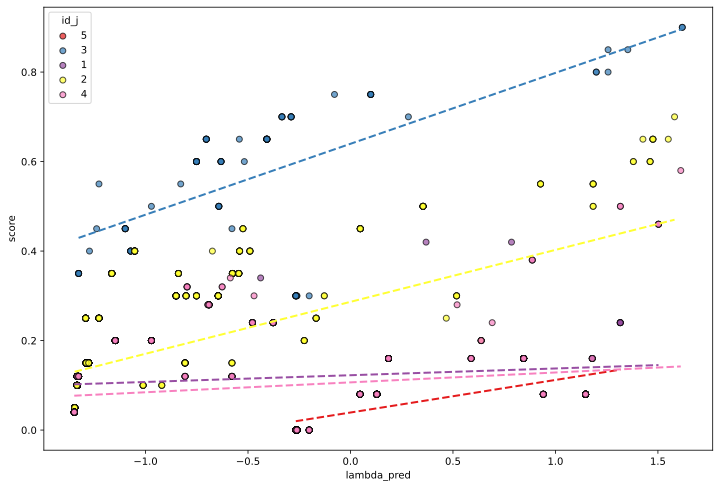

In [19]:
# We now show that there is a clear trend of correlation between the score and the predicted lambda from the models for each job_id
# Let's describe the prediction with a scatterplot

# Set plotting variables
cmap = plt.get_cmap('Set1')
plt.figure(figsize=(12, 8))

# export the unique ids for jobs
unique_ids = df_all['id_j'].unique()

# Produce a plot for each unique job_id
for i, uid in enumerate(df_all['id_j'].unique()):
    subset = df_all[df_all['id_j'] == uid]
    color = cmap(i / len(unique_ids))

    plt.scatter(subset['lambda_pred'], subset['score'],
                color=color,
                label=str(uid), edgecolor='black', alpha=0.7)

    # If there is more than one data point, compute and plot the trendline.
    if len(subset) > 1:
        coeffs = np.polyfit(subset['lambda_pred'], subset['score'], 1)
        p = np.poly1d(coeffs)
        x_vals = np.linspace(subset['lambda_pred'].min(), subset['lambda_pred'].max(), 100)
        y_vals = p(x_vals)

        plt.plot(x_vals, y_vals, color=color, linestyle='--', linewidth=2)

# Finalize plotting
plt.xlabel('lambda_pred')
plt.ylabel('score')
plt.legend(title='id_j')
plt.show()


In [20]:
ndcg_score(rank2relevance(df_test).reshape(1, -1), ranker.predict(transformed_test_data).reshape(1, -1), k=TOP_K)

np.float64(0.9684121737647647)

### Example Model Explanation with RankingSHAP

In [21]:
from findhr.xai.factual.ranking_shap import RankingShap
from scipy.stats import kendalltau

In [22]:
# Define the background data
# we use the training data of the candidates applying for the job with id_j = 3
background_data = pipeline_rank.transform(df_train[df_train['id_j'] == 3][pred_cols])

# Define the rank similarity coefficient for comparing the predicted ranking for explanations
rank_similarity_coefficient = lambda x, y: kendalltau(x, y)[0]
# rank_similarity_coefficient = lambda x, y: ndcg_score(x.reshape(1, -1), y.reshape(1, -1), k=TOP_K)


In [23]:
ranking_shap_explainer = RankingShap(
    permutation_sampler="kernel",
    background_data=background_data,
    original_model=ranker.predict,
    name="rankingshap",
    rank_similarity_coefficient=rank_similarity_coefficient,
)

In [24]:
# Select the explicand data
explicand_data = df_train[df_train['id_j'] == 3][pred_cols] #df_train[pred_cols].iloc[200:210, :]
# Transform the explicand data
transformed_explicand_data = pipeline_rank.transform(explicand_data)


In [25]:
# Get the explanation
out_exp = ranking_shap_explainer.get_query_explanation(transformed_explicand_data)

# Get the feature importance for the explicand data after renaming the features as fitness features
out_exp_renamed = {list_cols_fitness[k-1]: v for k, v in dict(out_exp).items()}
out_exp_renamed

  0%|          | 0/1 [00:00<?, ?it/s]

{'fitness_skills': np.float64(0.4467164530491562),
 'fitness_experience': np.float64(0.42041501346794374),
 'fitness_foreign': np.float64(0.06408317580340259),
 'fitness_gender': np.float64(0.05932525256721888),
 'fitness_education': np.float64(0.009460105112278572)}

In [26]:
# The most important features are skills and experience. The others have low importance. In particular, the small values of importance are due to approximation errors

Text(0.5, 0, 'Feature Importance')

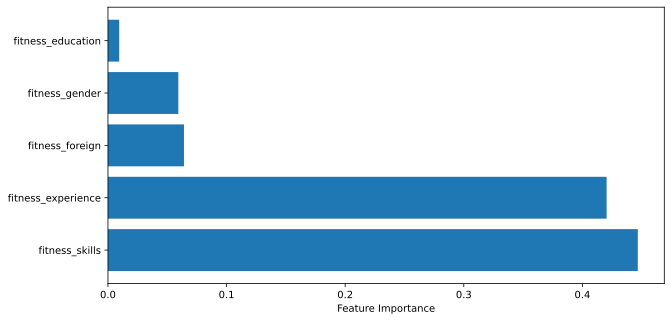

In [27]:
# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.barh(list(out_exp_renamed.keys()), list(out_exp_renamed.values()))
plt.xlabel('Feature Importance')